This notebook contains the functions applied to preprocess the image files:
- Downsampling
- Filtering

Also functions generating modulation power spectra (MPS) of the stimuli are included.

In [2]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
from soundsig.sound import BioSound 
from soundsig.sound import WavFile
import os

from preprocessing_final import generate_masks, generate_masks_2

# Downsampling
## Raw data (no deconvolution)

In [ ]:
series_index = [23] # Index of teseries e.g. 23
tseries_list = [f"tseries_{i}" for i in series_index]
factor = 2 # Downsampling Factor per axis

In [ ]:
# Downsampling once
# Nanmean slows the process sonsiderably and can be exchanged for mean()
# if there are no nan values in the images.
# Note: DF_by_F0_351_50 may be exchanged for DF_by_F0_201_50 for some tseries
for tseries in tqdm(tseries_list):
    DF_by_F0_351_50 = np.load(open("auditorycoding/F189/"+tseries+"/DF_by_F0_351_50.npy", "rb"))
    shape_original = DF_by_F0_351_50.shape
    DF_by_F0_351_50_downsampled_nomask = np.zeros(shape=(shape_original[0],int(shape_original[1]/factor),
                                                        int(shape_original[2]/factor)))
    for img in tqdm(range(shape_original[0])): # Each Image
        for y in range(0, shape_original[1], factor): # Each row in image
            for x in range(0, shape_original[2], factor): # Each column in image
                window = DF_by_F0_351_50[img,y:y+factor,x:x+factor]
                #DF_by_F0_201_50_downsampled[img,int(y/factor),int(x/factor)] = window.mean()
                DF_by_F0_351_50_downsampled_nomask[img,int(y/factor),int(x/factor)] = np.nanmean(window)
    pickle.dump(DF_by_F0_351_50_downsampled_nomask, open("auditorycoding/F189/"+tseries+"/DF_by_F0_351_50_50_downsampled_nomask.p", "wb"))

In [ ]:
# Downsampling again, everything works as above
for tseries in tqdm(tseries_list):
    DF_by_F0_351_50_downsampled_nomask = pickle.load(open("auditorycoding/F189/"+tseries+"/DF_by_F0_351_50_downsampled_nomask.p", "rb"))  
    shape_original = DF_by_F0_351_50_downsampled_nomask.shape
    DF_by_F0_351_50_downsampled2x_nomask = np.zeros(shape=(shape_original[0],int((shape_original[1]-1)/factor),int(shape_original[2]/factor)))
    for img in tqdm(range(shape_original[0])):
        for y in range(0, shape_original[1]-1, factor):
            for x in range(0, shape_original[2], factor):
                window = DF_by_F0_351_50_downsampled_nomask[img,y:y+factor,x:x+factor]
                DF_by_F0_351_50_downsampled2x_nomask[img,int(y/factor),int(x/factor)] = np.nanmean(window)


    pickle.dump(DF_by_F0_351_50_downsampled2x_nomask, open("auditorycoding/F189/"+tseries+"/DF_by_F0_351_50_downsampled2x_nomask.p", "wb"))

In [ ]:
# Print exemplary frames to check downsampling visually
frame = 1000
DF_by_F0_351_50_downsampled2x_nomask = pickle.load(open("auditorycoding/F189/"+tseries+"/DF_by_F0_351_50_downsampled2x_nomask.p", "rb"))
plt.imshow(DF_by_F0_351_50[frame], cmap="binary")
plt.show()
plt.imshow(DF_by_F0_351_50_downsampled_nomask[frame], cmap="binary")
plt.show()
plt.imshow(DF_by_F0_351_50_downsampled2x_nomask[frame], cmap="binary")
plt.show()

## Deconvolved Data
The only differences to the downsampling from above stems from the masks. Firstly, an adjusted ROI mask has been applied. Secondly, the deconvolution cannot handle nan values which means that the given data is already masked and images are flattened. To speed up computation exchange nanmean() with mean(). The relevance factor defines which pixels in the downsampled images are considered as masked and may be adjusted to exclude more or less pixels.

In [ ]:
series_index = [23]
factor = 2
relevance_cutoff = 0.25

In [ ]:
for index in tqdm(series_index):
    tseries = f"tseries_{index}"
    Y = np.load(open("auditorycoding/F189/"+tseries+f"/firdif_189_{index}_norm_roi.npy", "rb"))
    shape_original = Y.shape
    roi_morphed = np.load(open("auditorycoding/F189/masks/1_roi_morphed_new.npy", "rb"))
    target_shape = roi_morphed.shape
    roi_mask = roi_morphed.reshape((roi_morphed.shape[0] * roi_morphed.shape[1]))
    # Get images back to 2D
    Y_2d = np.empty((Y.shape[0],) + roi_mask.shape)
    Y_2d[:, roi_mask] = Y[:,:]
    Y_2d = np.reshape(Y_2d,(Y_2d.shape[0], int(target_shape[0]), int(target_shape[1]))) 
    
    Y_downsampled = np.zeros(shape=(shape_original[0],int(target_shape[0]/factor),int(target_shape[1]/factor)))
    for img in tqdm(range(shape_original[0])):
        for y in range(0, target_shape[0], factor):
            for x in range(0, target_shape[1], factor):
                window = Y_2d[img,y:y+factor,x:x+factor]

                if roi_morphed[y:y+factor,x:x+factor].mean() > relevance_cutoff:
                    #DF_by_F0_351_50_downsampled[img,int(y/factor),int(x/factor)] = window.mean()
                    Y_downsampled[img,int(y/factor),int(x/factor)] = np.nanmean(window)

                elif roi_morphed[y:y+factor,x:x+factor].mean() <= relevance_cutoff:
                    Y_downsampled[img,int(y/factor),int(x/factor)] = np.nan
                    
    pickle.dump(Y_downsampled, open("auditorycoding/F189/"+tseries+f"/firdif_189_{index}_norm_roi_downsampled.p", "wb"))

In [ ]:
factor = 2
relevance_cutoff = 0.25
# generate_masks_2 uses the adjusted ROI mask for the deconvolved images
mask, mask_downsampled, mask_downsampled2x, roi_morphed, roi_downsampled, roi_downsampled2x = generate_masks_2(0.25)
for index in tqdm(series_index):
    tseries = f"tseries_{index}"
    Y = pickle.load(open("auditorycoding/F189/"+tseries+f"/firdif_189_{index}_norm_roi_downsampled.p", "rb"))
    shape_original = Y.shape
    Y_downsampled = np.zeros(shape=(Y.shape[0],int(Y.shape[1]/factor),int(Y.shape[2]/factor)))
    for img in tqdm(range(shape_original[0])):
        for y in range(0, shape_original[1]-1, factor):
            for x in range(0, shape_original[2], factor):
                window = Y[img,y:y+factor,x:x+factor]

                if roi_downsampled[y:y+factor,x:x+factor].mean() > relevance_cutoff:
                    #DF_by_F0_351_50_downsampled[img,int(y/factor),int(x/factor)] = window.mean()
                    Y_downsampled[img,int(y/factor),int(x/factor)] = np.nanmean(window)

                elif roi_downsampled[y:y+factor,x:x+factor].mean() <= relevance_cutoff:
                    Y_downsampled[img,int(y/factor),int(x/factor)] = np.nan
                    
    pickle.dump(Y_downsampled, open("auditorycoding/F189/"+tseries+f"/firdif_189_{index}_norm_roi_downsampled2x.p", "wb"))

# Band-pass filter 
## Raw Data
Filter function originally created by authors of: https://pubmed.ncbi.nlm.nih.gov/30349107/,  doi: 10.1038/s41593-018-0247-5

In [ ]:
from bandpass_filter import lowhigh_normalize

relevance_cutoff = 0.25
ds = 4 # Downsampling factor
# Parameters for the filter (default values)
#sig_low=1 / 4
#sig_high=(100/5.4945054945054945) / 4
mask, mask_downsampled, mask_downsampled2x, roi_morphed, roi_downsampled, roi_downsampled2x = generate_masks(relevance_cutoff=relevance_cutoff)
mask_downsampled2x = mask_downsampled2x.astype(bool)
series_index = [23]

for idx in tqdm(series_index):
    DF_by_F0_351_50_downsampled2x_nomask = pickle.load(open(f"auditorycoding/F189/tseries_{idx}/DF_by_F0_351_50_downsampled2x_nomask.p", "rb"))  
    DF_by_F0_351_50_downsampled2x_filtered = np.zeros(shape = DF_by_F0_351_50_downsampled2x_nomask.shape)
    for i in tqdm(range(DF_by_F0_351_50_downsampled2x_nomask.shape[0])):
        DF_by_F0_351_50_downsampled2x_filtered[i,:,:] = lowhigh_normalize(DF_by_F0_351_50_downsampled2x_nomask[i,:,:], mask=mask_downsampled2x)

    pickle.dump(DF_by_F0_351_50_downsampled2x_filtered, open(f"auditorycoding/F189/tseries_{idx}/DF_by_F0_351_50_downsampled2x_nomask_filtered_{relevance_cutoff}.p", "wb"))

## Deconvolved Data

In [ ]:
# Everything as above exept different mask and file names

relevance_cutoff = 0.25
ds = 4
#sig_low=1 / 4
#sig_high=(100/5.4945054945054945) / 4
mask, mask_downsampled, mask_downsampled2x, roi_morphed, roi_downsampled, roi_downsampled2x = generate_masks_2(relevance_cutoff=relevance_cutoff)
mask_downsampled2x = mask_downsampled2x.astype(bool)
series_index = [23]

for idx in tqdm(series_index):
    DF_by_F0_201_50_downsampled2x_nomask = pickle.load(open(f"auditorycoding/F189/tseries_{idx}/firdif_189_{idx}_norm_roi_downsampled2x.p", "rb"))  
    DF_by_F0_201_50_downsampled2x_filtered = np.zeros(shape = DF_by_F0_201_50_downsampled2x_nomask.shape)
    for i in tqdm(range(DF_by_F0_201_50_downsampled2x_nomask.shape[0])):
        DF_by_F0_201_50_downsampled2x_filtered[i,:,:] = lowhigh_normalize(DF_by_F0_201_50_downsampled2x_nomask[i,:,:], mask=mask_downsampled2x)
        
    pickle.dump(DF_by_F0_201_50_downsampled2x_filtered, open(f"auditorycoding/F189/tseries_{idx}/firdif_189_{idx}_norm_roi_downsampled2x_filtered_{relevance_cutoff}.p", "wb"))

# Modulation Power Spectrum (MPS)
We create a dictionary containing the MPS of each stimulus and plot them. MPS are created using Soundsig BioSound package.

In [ ]:
# Plot flag to decide whether or not to plot output
plotMe = False
normalize = False

mps_dict = {} # dictionary of the MPS'
# Find all the wave files 
isound = 0
path = "auditorycoding/audiostimfiles/ComplexAudioStimFiles_03_2021/" # Location of .wav files
stimulus_names = [file for file in os.listdir(path)
                 if os.path.isfile(os.path.join(path, file))]
for fname in stimulus_names:
    if fname.endswith('.wav'):
        isound += 1
        
        # Read the sound file
        print ('Processing sound %d:%s\n' % (isound, fname))
        soundIn = WavFile(file_name=path+fname) 
        filename, file_extension = os.path.splitext(fname)
        
        
        # Normalize if wanted
        if normalize :
            maxAmp = np.abs(soundIn.data).max() 
        else :
            maxAmp = 1.0
    
    # Create BioSound Object
        myBioSound = BioSound(soundWave=soundIn.data.astype(float)/maxAmp, fs=float(soundIn.sample_rate))
             
    # Calculate the spectrogram and the rms
    # Default parameters of soundsig tutorial used but max_freq adapted to 4000Hz
        myBioSound.spectroCalc(spec_sample_rate=1000, freq_spacing = 50, min_freq=0, max_freq=4000)
        myBioSound.rms = myBioSound.sound.std() 
       
    # Calculate amplitude enveloppe
        myBioSound.ampenv(cutoff_freq = 20, amp_sample_rate = 1000)
       
    # Calculate the power spectrum
        myBioSound.spectrum(f_high=4000)
    
    # Calculate fundamental and related values.  These are the default values.
    # For the estimation of the fundamental, four methods are available: 
    # 'AC' - Peak of the auto-correlation function
    # 'ACA' - Peak of envelope of auto-correlation function 
    # 'Cep' - First peak in cepstrum 
    # 'Stack' - Fitting of harmonic stacks (default - works well for zebra finches)
    
        myBioSound.fundest(maxFund = 1500, minFund = 300, lowFc = 200, highFc = 6000, 
                           minSaliency = 0.5, debugFig = 0, 
                           minFormantFreq = 500, maxFormantBW = 500, windowFormant = 0.1,
                           method='Stack')
      
    # Calculate the MPS
        myBioSound.mpsCalc(window=0.1, Norm = True)
                

    # Save the results
        logMPS = 10.0*np.log10(myBioSound.mps)
        maxMPS = logMPS.max()
        minMPS = maxMPS-50 # 50 is default DBNOISE noise value from soundsig
        logMPS[logMPS < minMPS] = minMPS
        mps_dict[filename] = logMPS

pickle.dump(mps_dict, open("mps_dict.p", "wb"))

aerosol+spray+shake
(77, 101)


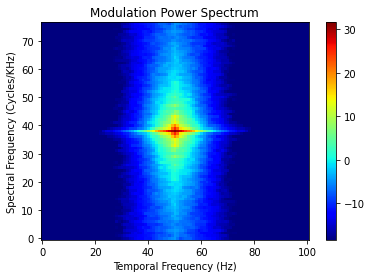

coyote3
(77, 101)


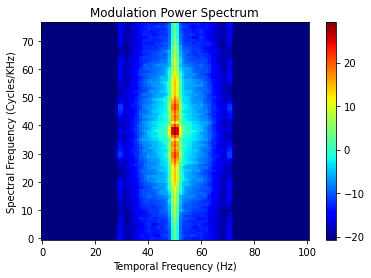

Duck-quacking-sound
(77, 101)


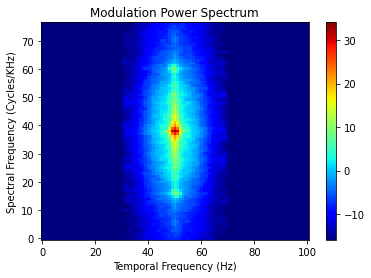

elephant3
(77, 101)


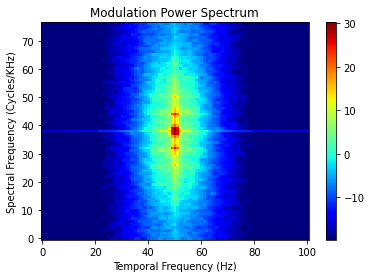

guinea_pig_shriek
(77, 101)


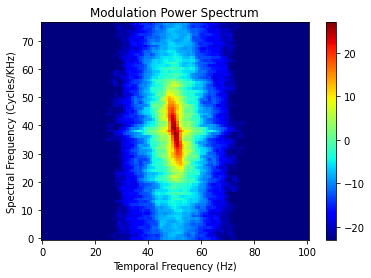

hippo2
(77, 101)


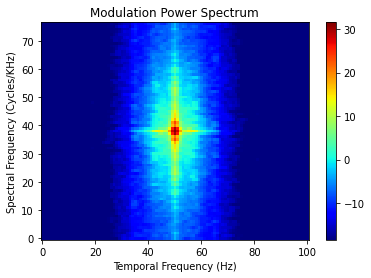

Howl
(77, 101)


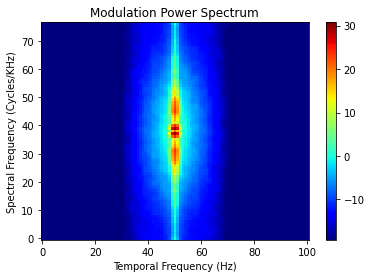

hyena
(77, 101)


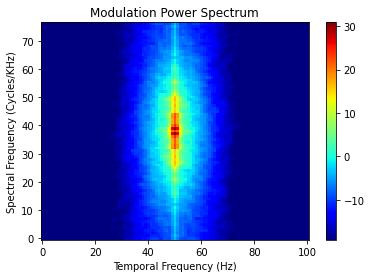

JAGUARS
(77, 101)


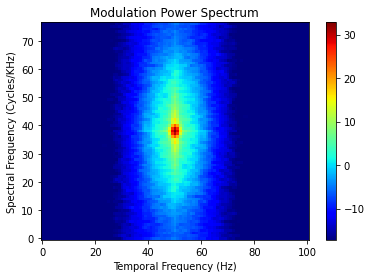

oceanlap
(77, 101)


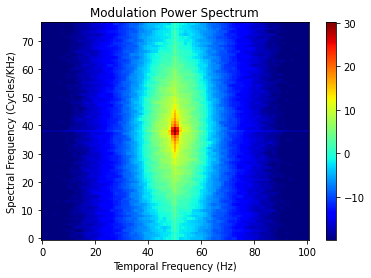

OOGAhorn
(77, 101)


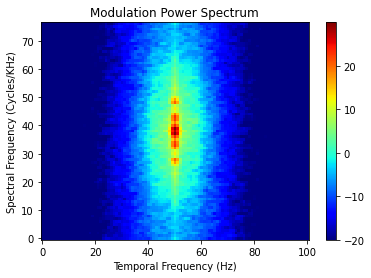

panther7
(77, 101)


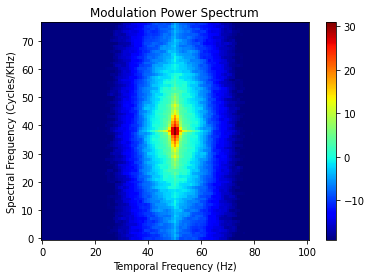

Scissor_Snip
(77, 101)


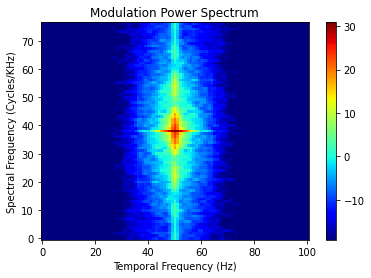

Scream+20
(77, 101)


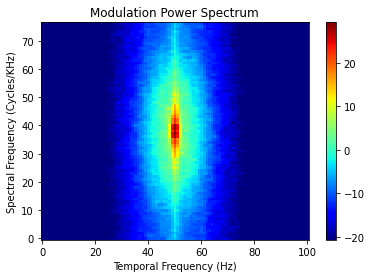

Scream+Male+2
(77, 101)


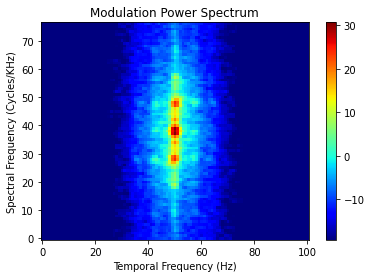

SQMonkey
(77, 101)


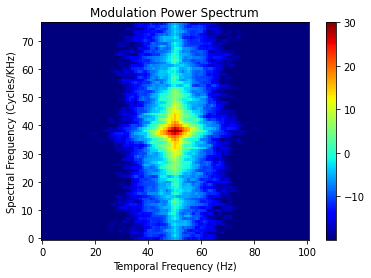

whalesurfaces
(77, 101)


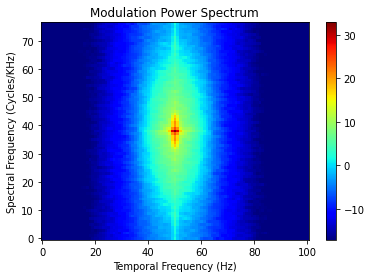

windy
(77, 101)


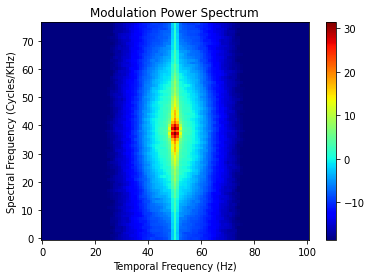

wolf3
(77, 101)


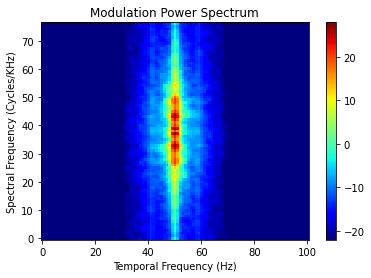

KEYBD8
(77, 101)


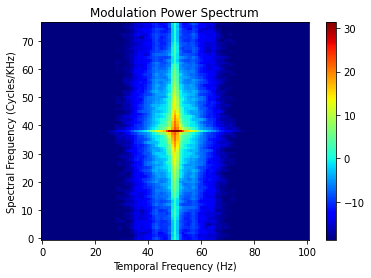

dog
(77, 101)


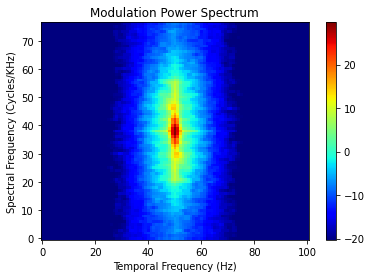

Chomp+1
(77, 101)


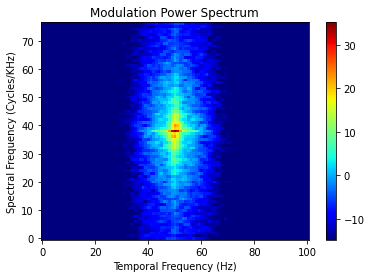

Turkey-noises
(77, 101)


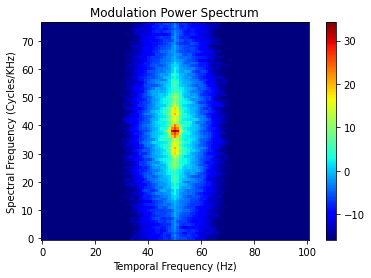

BMW+DRIVEBY
(77, 101)


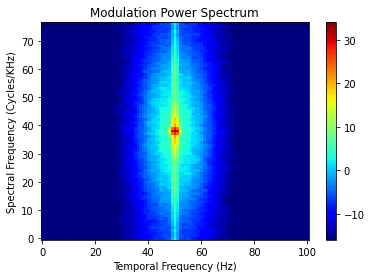

Pigeon-coo
(77, 101)


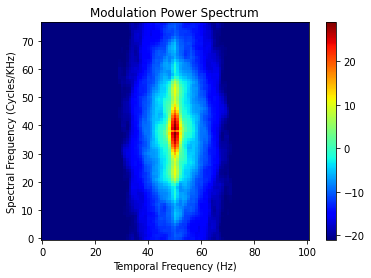

pig
(77, 101)


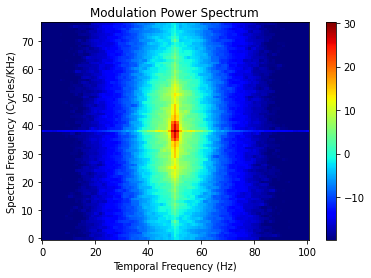

light+rain+loop
(77, 101)


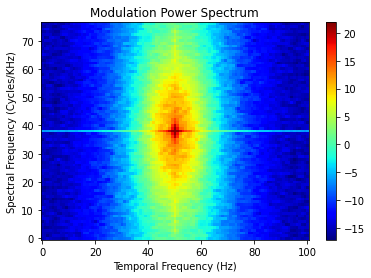

ploar
(77, 101)


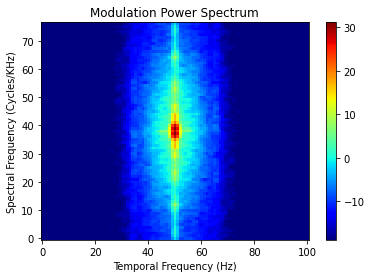

deepbark
(77, 101)


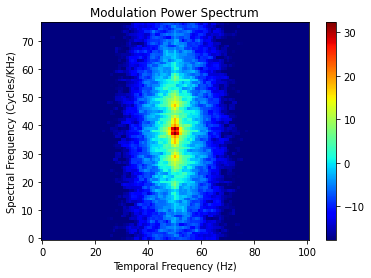

monkeymacaque
(77, 101)


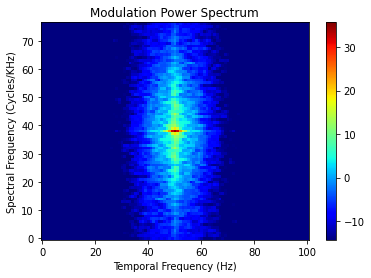

dolphin3
(77, 101)


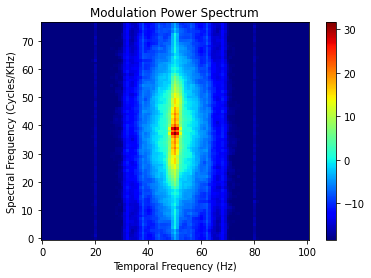

hyena1
(77, 101)


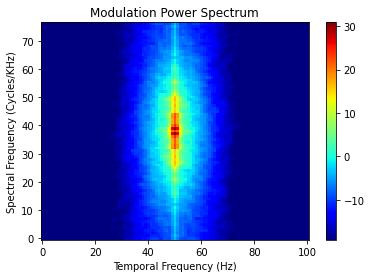

natterers
(77, 101)


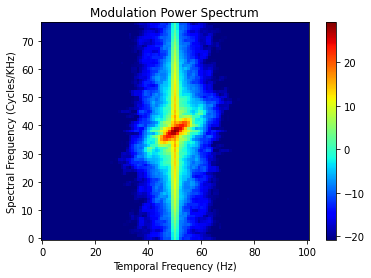

electricguitar
(77, 101)


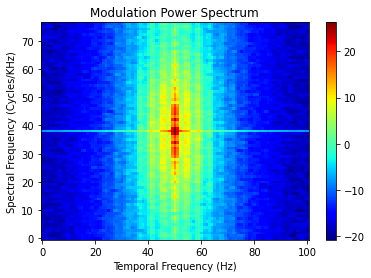

crocodile
(77, 101)


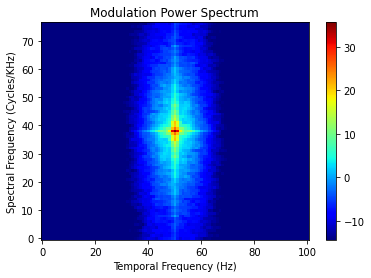

HowlCoyoteC
(77, 101)


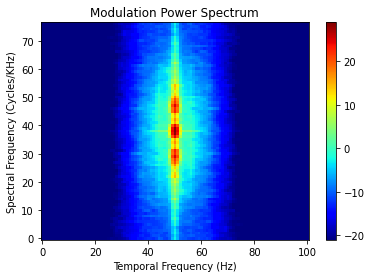

flamesound
(77, 101)


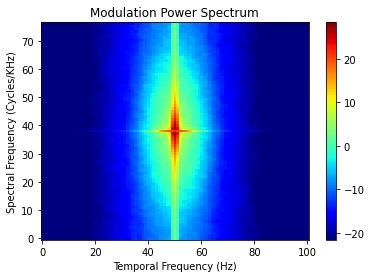

Tiger6
(77, 101)


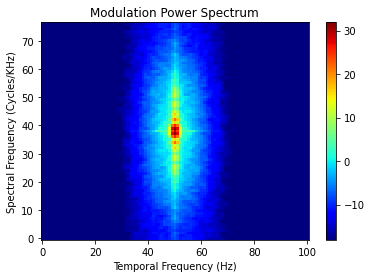

LotsOfBats
(77, 101)


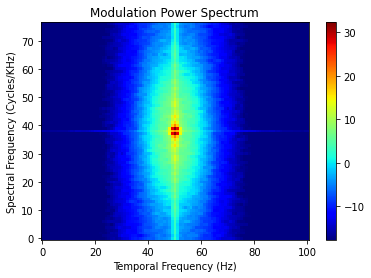

trafficjam
(77, 101)


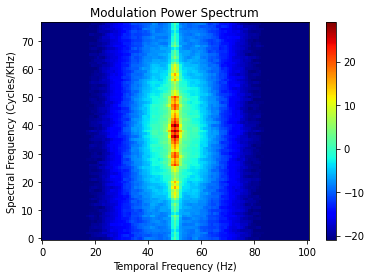

GreySeal
(77, 101)


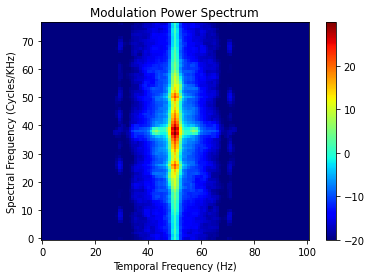

keys
(77, 101)


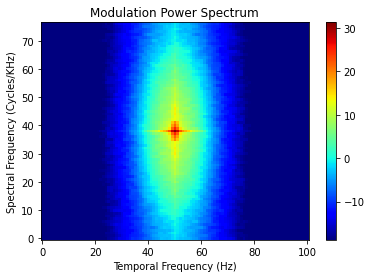

bat+hit+ball
(77, 101)


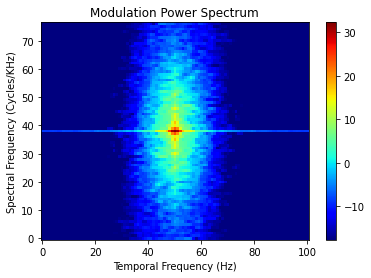

Timer2
(77, 101)


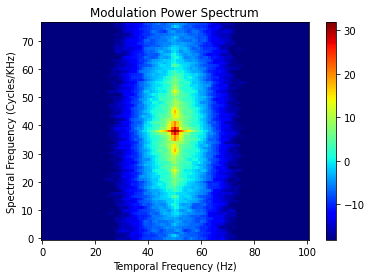

In [16]:
stimulus = np.load("auditorycoding/F189/tseries_23/stimulus.npy")
stimparams = stimparams = pickle.load(open("auditorycoding/F189/tseries_23/stimparams.dict", "rb"))
path = "auditorycoding/audiostimfiles/ComplexAudioStimFiles_03_2021/"
stimulus_names = [file for file in os.listdir(path)
                 if os.path.isfile(os.path.join(path, file))]
mps_dict = pickle.load(open("mps_dict.p", "rb"))
for i in stimparams["stimDuration"]:
    stim = i[0]
    name = stimulus_names[stim][:-4]
    print(name)
    cmap = plt.get_cmap('jet')
    plt.imshow(mps_dict[name], interpolation='nearest', aspect='auto', origin='lower', cmap=cmap)
    print(mps_dict[name].shape)
    plt.ylabel('Spectral Frequency (Cycles/KHz)')
    plt.xlabel('Temporal Frequency (Hz)')
    plt.colorbar()
    #plt.ylim((0,wf.max()*1e3))
    plt.title('Modulation Power Spectrum')
    plt.show()